# Black Hole Spectra

Black hole spectra can be generated by combining a `BlackHoles` object with an ``EmissionModel``, translating the physical properties of the blackhole(s) (e.g. `mass`, `accretion_rate`, etc.) to a spectral energy distribution.

These models are described in detail in the [emission model docs](../emission_models/emission_models.rst). Here, we'll use an instance of a ``UnifiedAGN`` model for demonstration purposes.

The following sections demonstrate the generation of combined spectra (which is the same for both parametric and particle ``BlackHoles``) and per--particle spectra. 

In [1]:
import numpy as np
from synthesizer import Grid
from synthesizer.emission_models import (
    AttenuatedEmission,
    DustEmission,
    UnifiedAGN,
)
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.parametric import BlackHole
from unyt import K, Msun, deg, yr

# Get the NLR and BLR grids
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")
blr_grid = Grid("test_grid_agn-blr", grid_dir="../../../tests/test_grid")

uniagn = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Greybody(1000 * K, 1.5),
)

blackhole = BlackHole(
    mass=1e8 * Msun,
    inclination=60 * deg,
    accretion_rate=1 * Msun / yr,
    metallicity=0.01,
)


## Integrated spectra

To generate integrated spectra we simply call the component's ``get_spectra`` method. This method will populate the component's ``spectra`` attribute with a dictionary containing [Sed objects](../sed/sed.rst) for each spectra in the ``EmissionModel``.
It will also return the spectra at the root of the ``EmissionModel``.

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


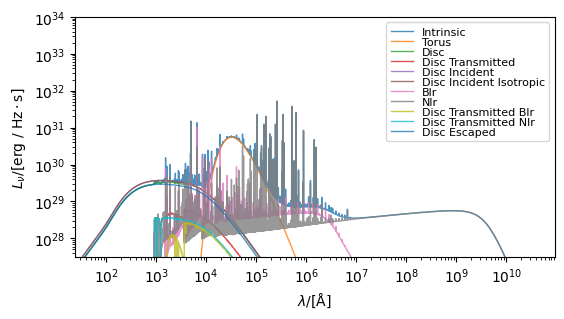

In [2]:
# Get the spectra using a unified agn model (instantiated elsewhere)
spectra = blackhole.get_spectra(uniagn)

fig, ax = blackhole.plot_spectra(
    show=True, ylimits=(10**27.5, 10**34.0), figsize=(6, 4)
)

### Including dust attenuation

We can also generate spectra including attenuation and emission from diffuse dust along the line of sight to the black hole.
We do this by combining the ``UnifiedAGN`` model with models defining these attenuation and emission contributions.

First we define the emission models (for more details see the [emission model docs](../emission_models/custom_models.ipynb)).

In [3]:
tau_v = 0.5
dust_curve = PowerLaw(slope=-1.0)
dust_emission_model = Greybody(30 * K, 1.2)

# Define an emission model to attenuate the intrinsic AGN emission
att_model = AttenuatedEmission(
    dust_curve=dust_curve,
    apply_dust_to=uniagn,
    tau_v=tau_v,
    emitter="blackhole",
)

# And now include the dust emission
dust_model = DustEmission(
    dust_emission_model=dust_emission_model,
    dust_lum_intrinsic=uniagn,
    dust_lum_attenuated=att_model,
    emitter="blackhole",
)

We then follow the same process of calling ``get_spectra`` with the new model.
The plot here shows luminosity rather than spectral energy density.

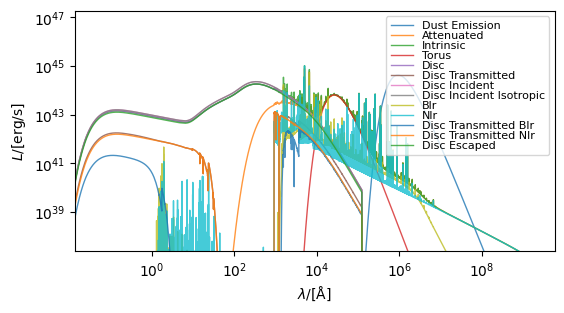

In [4]:
spectra = blackhole.get_spectra(dust_model)

fig, ax = blackhole.plot_spectra(quantity_to_plot="luminosity", figsize=(6, 4))

The spectra returned by ``get_spectra`` is the "dust_emission" spectra at the root of the emission model.

In [5]:
print(spectra)

+-----------------------------------------------------------------------------------------+
|                                           SED                                           |
+-----------------------+-----------------------------------------------------------------+
| Attribute             | Value                                                           |
+-----------------------+-----------------------------------------------------------------+
| bolometric_luminosity | 4.89e+44 erg/s                                                  |
+-----------------------+-----------------------------------------------------------------+
| redshift              | 0                                                               |
+-----------------------+-----------------------------------------------------------------+
| lam (9244,)           | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+-----------------------+-------------------------------------------------------

However, all the spectra are stored within a dictionary under the ``spectra`` attribute.

In [6]:
print(blackhole.spectra)

{'disc_escaped': <synthesizer.sed.Sed object at 0x7ff17ca8acb0>, 'disc_transmitted_nlr': <synthesizer.sed.Sed object at 0x7ff0e908b9a0>, 'disc_transmitted_blr': <synthesizer.sed.Sed object at 0x7ff13092fe20>, 'nlr': <synthesizer.sed.Sed object at 0x7ff0e92bd0c0>, 'blr': <synthesizer.sed.Sed object at 0x7ff0e92bcfd0>, 'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7ff0e92bd090>, 'disc_incident': <synthesizer.sed.Sed object at 0x7ff0e8ed9f60>, 'disc_transmitted': <synthesizer.sed.Sed object at 0x7ff0e8eda590>, 'disc': <synthesizer.sed.Sed object at 0x7ff17ca8b6a0>, 'torus': <synthesizer.sed.Sed object at 0x7ff17ca8b6d0>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ff17ca88250>, 'attenuated': <synthesizer.sed.Sed object at 0x7ff17ca8bb20>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ff17ca6aa10>}


## Particle spectra

To demonstrate the particle spectra functionality we first generate some mock particle black hole data, and initialise a ``BlackHoles`` object.

In [7]:
from synthesizer.particle import BlackHoles

# Make fake properties
n = 4
masses = 10 ** np.random.uniform(low=7, high=9, size=n)  # Msun
coordinates = np.random.normal(0, 1.5, (n, 3))  # cMpc
accretion_rates = 10 ** np.random.uniform(
    low=-2, high=1, size=n
)  # Msun  # Msun / yr
metallicities = np.full(n, 0.01)

# And get the black holes object
blackholes = BlackHoles(
    masses=masses,
    coordinates=coordinates,
    accretion_rates=accretion_rates,
    metallicities=metallicities,
)

To generate a spectra for each black hole (per--particle) we use the same emission model, but swap out the ``get_spectra`` method (used for integrated spectra) with the ``get_particle_spectra`` method (only particle components have this method).

In [8]:
spectra = blackholes.get_particle_spectra(dust_model, verbose=True)

Again, the returned spectra is the "dust_emission" spectra from the root of the model.

In [9]:
print(spectra)

+----------------------------------------------------------------------------------------------+
|                                             SED                                              |
+----------------------------+-----------------------------------------------------------------+
| Attribute                  | Value                                                           |
+----------------------------+-----------------------------------------------------------------+
| redshift                   | 0                                                               |
+----------------------------+-----------------------------------------------------------------+
| lam (9244,)                | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+----------------------------+-----------------------------------------------------------------+
| nu (9244,)                 | 1.00e+07 Hz -> 2.31e+22 Hz (Mean: 8.51e+19 Hz)                  |
+----------------------------+

While the spectra produced by ``get_particle_spectra`` are stored in a dictionary under the ``particle_spectra`` attribute.

In [10]:
print(blackholes.particle_spectra)

{'disc_escaped': <synthesizer.sed.Sed object at 0x7ff0e8e61e70>, 'disc_transmitted_nlr': <synthesizer.sed.Sed object at 0x7ff1308f7370>, 'disc_transmitted_blr': <synthesizer.sed.Sed object at 0x7ff0e90881f0>, 'nlr': <synthesizer.sed.Sed object at 0x7ff0e92bcfa0>, 'blr': <synthesizer.sed.Sed object at 0x7ff0e92bc880>, 'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7ff0e9088580>, 'disc_incident': <synthesizer.sed.Sed object at 0x7ff0e908bd60>, 'disc_transmitted': <synthesizer.sed.Sed object at 0x7ff0e8e628f0>, 'disc': <synthesizer.sed.Sed object at 0x7ff0e8e61570>, 'torus': <synthesizer.sed.Sed object at 0x7ff0e8e601f0>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ff0e8e61c60>, 'attenuated': <synthesizer.sed.Sed object at 0x7ff0e8e62c20>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ff0e8e62bf0>}


### Integrating spectra

To get integrated spectra from the particle spectra we just generated, we can call the ``integrate_particle_spectra`` method. This method will sum the individual spectra and populate the ``spectra`` dictionary.

Note, we can also integrate individual spectra using the ``Sed.sum()`` method.

{}
{'disc_escaped': <synthesizer.sed.Sed object at 0x7ff0e8e62830>, 'disc_transmitted_nlr': <synthesizer.sed.Sed object at 0x7ff0e8ed8a60>, 'disc_transmitted_blr': <synthesizer.sed.Sed object at 0x7ff0e905b0d0>, 'nlr': <synthesizer.sed.Sed object at 0x7ff13092ffd0>, 'blr': <synthesizer.sed.Sed object at 0x7ff0e94e8ca0>, 'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7ff0e9320340>, 'disc_incident': <synthesizer.sed.Sed object at 0x7ff0e8f45f30>, 'disc_transmitted': <synthesizer.sed.Sed object at 0x7ff0e92bd120>, 'disc': <synthesizer.sed.Sed object at 0x7ff0e92bd0f0>, 'torus': <synthesizer.sed.Sed object at 0x7ff0e8e60b50>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ff0e8e61150>, 'attenuated': <synthesizer.sed.Sed object at 0x7ff0e8e615a0>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ff0e8e60ee0>}


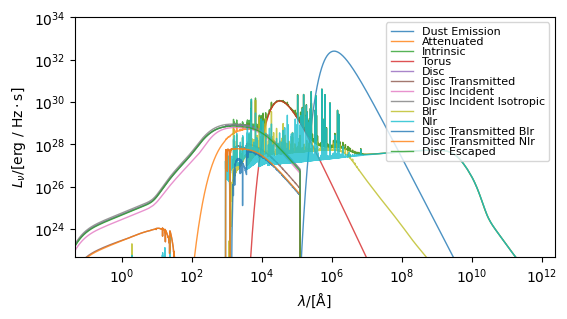

In [11]:
print(blackholes.spectra)
blackholes.integrate_particle_spectra()
print(blackholes.spectra)

fig, ax = blackholes.plot_spectra(show=True, figsize=(6, 4))